In [1]:
import pandas as pd
import os

current_path = os.getcwd()
print(f"Initial CWD: {current_path}")

if os.path.basename(current_path).lower() == "src":
    print(f"Current directory is already named 'src': {current_path}")
elif os.path.isdir(os.path.join(current_path, "src")):
    print(f"Changing CWD to 'src' subdirectory: {os.path.join(current_path, 'src')}")
    os.chdir(os.path.join(current_path, "src"))
else:
    raise FileNotFoundError(
        f"Could not find 'src' directory. CWD: {current_path}. "
        "Ensure 'src' is a subdirectory or your notebook is in 'src'."
    )
print(f"Final CWD: {os.getcwd()}")

from backtesting.platform_conector_mt5.platform_connector_mt5 import BacktestPlatformConnector
from backtesting.data_source_mt5.data_source_mt5 import MT5BacktestDataSource
from portfolio.portfolio import Portfolio
from backtesting_director.backtesting_director import BacktestingDirector
from strategy_manager.strategy_manager import StrategyManager
from strategy_manager.properties.strategy_manager_properties import MACrossoverProps, RSIProps
from position_sizer.position_sizer import PositionSizer
from position_sizer.properties.position_sizer_properties import FixedSizingProps
from risk_manager.risk_manager import RiskManager
from risk_manager.properties.risk_manager_properties import MaxLeverageFactorRiskProps
from backtesting.data_display_mt5.data_display_mt5 import DataDisplayMT5
from backtesting.order_executor_mt5.order_executor_mt5 import BacktestOrderExecutor
from queue import Queue

Initial CWD: c:\Mac\Home\Documents\PythonTradingBot
Changing CWD to 'src' subdirectory: c:\Mac\Home\Documents\PythonTradingBot\src
Final CWD: c:\Mac\Home\Documents\PythonTradingBot\src


In [2]:
symbols = ["EURUSD"]
timeframe = "H1"
magic_number = 12345
volume = 0.10
max_leverage_factor = 5
start_date = "2022-01-01"
end_date = "2023-01-01"

mac_props = MACrossoverProps(
    timeframe=timeframe,
    slow_period=10,
    fast_period=5,
)

rsi_props = RSIProps(
    timeframe=timeframe,
    rsi_period=14,
    rsi_upper=70.0,
    rsi_lower=30.0,
    sl_points=200,
    tp_points=400,
)

events_queue = Queue()

BACKTEST_CONNECT = BacktestPlatformConnector()
initial_balance = BACKTEST_CONNECT.get_balance()

BACKTEST_DATA_SOURCE = MT5BacktestDataSource(events_queue=events_queue, symbols=symbols, timeframe=timeframe,
                                    start_date=start_date, end_date=end_date)

PORTFOLIO = Portfolio(magic_number=magic_number, platform_connector=BACKTEST_CONNECT)

BACKTEST_ORDER_EXECUTOR = BacktestOrderExecutor(
    platform_connector=BACKTEST_CONNECT,
    events_queue=events_queue,
    data_source=BACKTEST_DATA_SOURCE,
    portfolio=PORTFOLIO
)

STRATEGY_MANAGER = StrategyManager(
    events_queue=events_queue,
    data_source=BACKTEST_DATA_SOURCE,
    portfolio=PORTFOLIO,
    order_executor=BACKTEST_ORDER_EXECUTOR,
    strategy_properties=mac_props
)

POSITION_SIZER = PositionSizer(
    events_queue=events_queue,
    data_source=BACKTEST_DATA_SOURCE,
    sizing_properties=FixedSizingProps(volume=volume)
)

RISK_MANAGER = RiskManager(
    events_queue=events_queue,
    data_source=BACKTEST_DATA_SOURCE,
    portfolio=PORTFOLIO,
    risk_properties=MaxLeverageFactorRiskProps(max_leverage_factor=max_leverage_factor)
)

BACKTESTING_DIRECTOR = BacktestingDirector(
    events_queue=events_queue,
    data_source=BACKTEST_DATA_SOURCE,
    strategy_manager=STRATEGY_MANAGER,
    position_sizer=POSITION_SIZER,
    risk_manager=RISK_MANAGER,
    order_executor=BACKTEST_ORDER_EXECUTOR,
)

BACKTESTING_DIRECTOR.run()

print("\n--- Backtest Finished ---")
print(f"Initial Balance: {initial_balance:.2f}")
final_balance = BACKTEST_CONNECT.get_balance()
print(f"Final Balance: {final_balance:.2f}")
print(f"Final Equity: {BACKTEST_CONNECT.get_equity():.2f}")

trade_log_df = pd.DataFrame(BACKTEST_ORDER_EXECUTOR.get_trade_log())

2025-06-10 19:08:54 - Receiving DATA EVENT from: EURUSD - last close price: 1.13729
2025-06-10 19:08:54 - Receiving DATA EVENT from: EURUSD - last close price: 1.1362
2025-06-10 19:08:54 - Receiving DATA EVENT from: EURUSD - last close price: 1.13586
2025-06-10 19:08:54 - Receiving DATA EVENT from: EURUSD - last close price: 1.13426
2025-06-10 19:08:54 - Receiving DATA EVENT from: EURUSD - last close price: 1.13482
2025-06-10 19:08:54 - Receiving DATA EVENT from: EURUSD - last close price: 1.13405
Signal generated: StrategyType.SELL for EURUSD
2025-06-10 19:08:54 - Receiving STRATEGY EVENT for: StrategyType.SELL from: EURUSD 
2025-06-10 19:08:54 - Receiving SIZING EVENT with position size: 0.1 for: StrategyType.SELL from: EURUSD 
()
2025-06-10 19:08:54 - Receiving ORDER EVENT with position size: 0.1 for: StrategyType.SELL from: EURUSD 
BACKTEST EXEC: Market sell 0.1 EURUSD @ 1.13405 at 2022-01-03 06:00:00
2025-06-10 19:08:54 - Receiving EXECUTION EVENT for: StrategyType.SELL in EURUSD 

In [3]:
if not trade_log_df.empty:
    print("\n--- Trade Log ---")
    print(trade_log_df.head())

else:
    print("No trades were executed.")


--- Trade Log ---
                                 ticket  symbol open_side  entry_price  \
0  7a8f0a72-d39f-419c-b02b-7e189cb789ea  EURUSD      sell      1.13405   
1  f4765ca6-2190-4cbb-b6ea-3eb7b86ec0b4  EURUSD       buy      1.13554   
2  720a6968-ee3f-4471-8382-441cd1aa8423  EURUSD      sell      1.13061   
3  1f0a0792-47d2-4b7a-890d-d0457eccd39c  EURUSD       buy      1.13020   
4  c79c0511-f952-49a0-864e-e07de32646b8  EURUSD      sell      1.12930   

           entry_time  volume close_side  exit_price           exit_time  \
0 2022-01-03 06:00:00     0.1        buy     1.13554 2022-01-03 12:00:00   
1 2022-01-03 12:00:00     0.1       sell     1.13061 2022-01-03 16:00:00   
2 2022-01-03 16:00:00     0.1        buy     1.13020 2022-01-04 01:00:00   
3 2022-01-04 01:00:00     0.1       sell     1.12930 2022-01-04 08:00:00   
4 2022-01-04 08:00:00     0.1        buy     1.12938 2022-01-04 19:00:00   

   profit  magic   sl   tp  
0   -14.9  12345  0.0  0.0  
1   -49.3  12345  0.0

In [4]:
if not trade_log_df.empty:
    display = DataDisplayMT5(trade_log_df=trade_log_df, initial_balance=initial_balance)
    display.display_summary()

else:
    print("No trades were executed.")


--- Backtest Summary ---
Total Trades: 695
Total Profit/Loss: -1038.40
Gross Profit: 8625.20
Gross Loss: -9663.60
Winning Trades: 267
Losing Trades: 427
Win Rate (%): 38.42
Average Win ($): 32.30
Average Loss ($): -22.63
Profit Factor: 0.89
Max Drawdown ($): -1251.10
Max Drawdown (%): 1.25
Sharpe Ratio (simplificado): -0.62
---------------------------



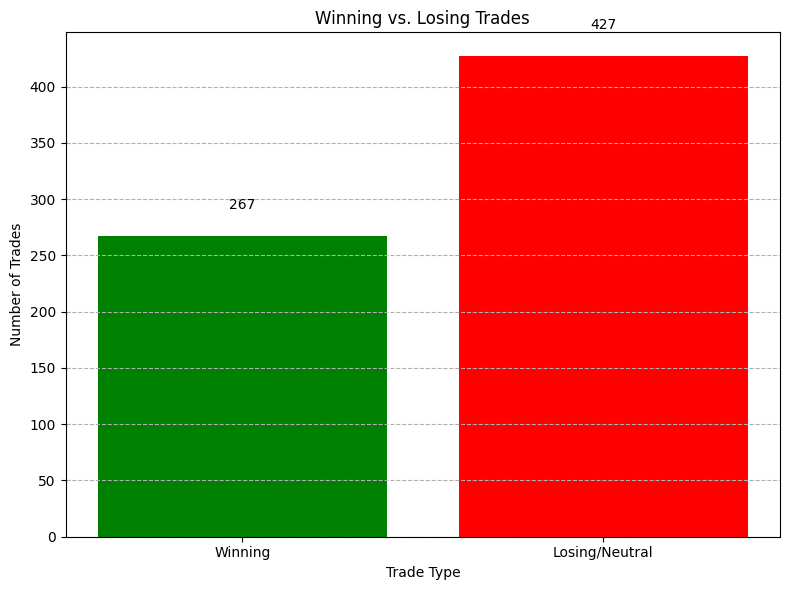

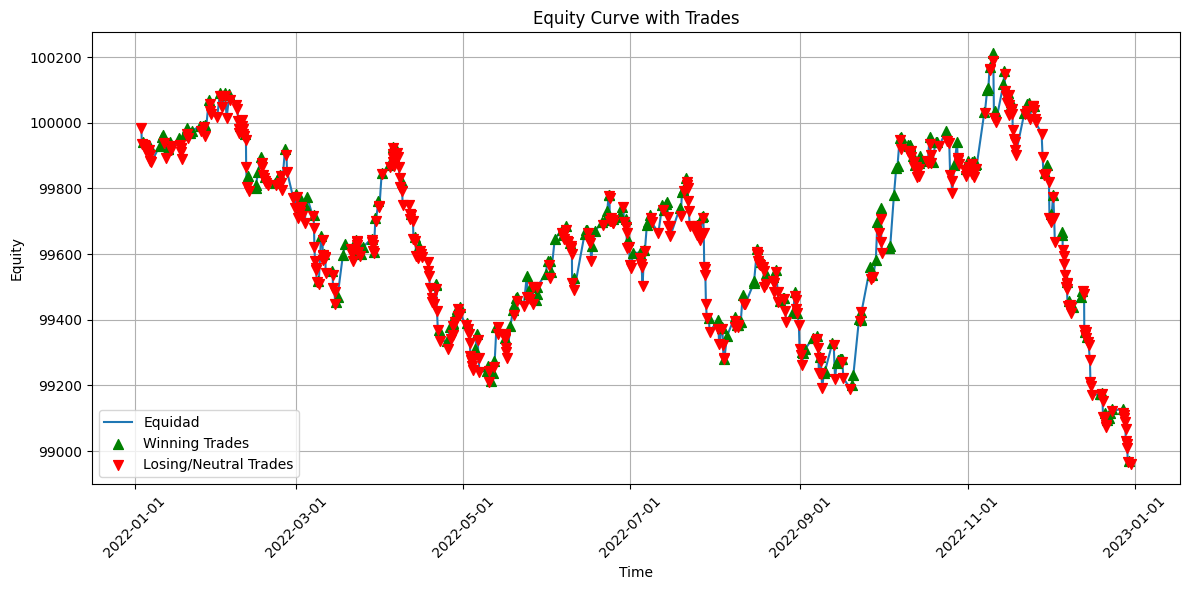

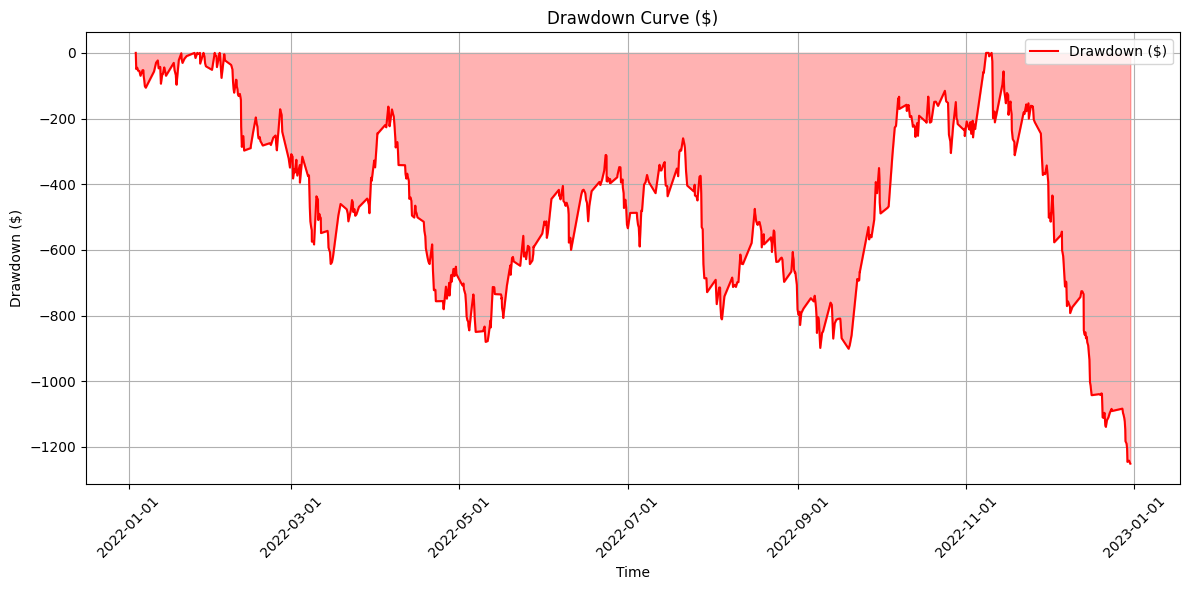

In [5]:
if not trade_log_df.empty:
    display.plot_win_loss_trades_bar_chart()
    display.plot_equity_curve_and_trades()
    display.plot_drawdown_curve()

else:
    print("No trades were executed.")